In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np
import pandas as pd
import functools
import torch
from torch import nn
sns.set()

## Discrete action distributions

In [2]:
class DiscretePolicy(nn.Module):
    def __init__(self, n_actions, init_probs=None):
        super(DiscretePolicy, self).__init__()
        self.n_actions = n_actions
        if init_probs is None:
            init_probs = torch.ones([n_actions]) / n_actions
        self.logits = nn.Parameter(torch.log(torch.Tensor(init_probs)))
        
    def forward(self):
        weights = torch.exp(self.logits)
        return weights / torch.sum(weights)
        
    def sample(self, p, n_samples):
        dist = torch.distributions.categorical.Categorical(p)
        actions = dist.sample(sample_shape=torch.Size([n_samples]))
        return actions.long()
    
    def get_log_likelihood(self, p, actions):
        dist = torch.distributions.categorical.Categorical(p)
        return dist.log_prob(actions)
    
    def calc_kl(self, p, q):
        return torch.sum(p * (torch.log(p + 1e-10) - torch.log(q + 1e-10)))
    
    def plot(self, ax, n_actions=None):
        p = self().detach()
        if n_actions is None:
            n_actions = self.n_actions
        sns.barplot(x=np.arange(n_actions), y=p[:n_actions], ax=ax)
        ax.set_xlabel('Action')
        ax.set_ylabel('PDF')
        
class Discrete2DPolicy(DiscretePolicy):
    def __init__(self, n_actions_per_dim, init_probs=None):
        self.n_actions_per_dim = n_actions_per_dim
        if init_probs is not None:
            init_probs = np.array(init_probs).flatten()
        super(Discrete2DPolicy, self).__init__(n_actions_per_dim ** 2, init_probs)
    
    def plot(self, ax, colorbar_ax=None):
        p = self().detach()
        if colorbar_ax is not None:
            cbar = True
        else:
            cbar = False
        sns.heatmap(p.reshape(self.n_actions_per_dim, self.n_actions_per_dim),
                    ax=ax, vmin=0, vmax=1, square=True, cbar=cbar, cbar_ax=colorbar_ax,
                    cmap=sns.cm.rocket_r, linewidths=.1)

## PPO on a single state

In [3]:
def adv_normalize(adv):
    std = adv.std()

    assert std != 0. and not torch.isnan(std), 'Need nonzero std'
    n_advs = (adv - adv.mean())/(adv.std()+1e-8)
    return n_advs

def surrogate_reward(adv, *, new, old, clip_eps=None, normalize_adv=True):
    log_ps_new, log_ps_old = new, old

    # Normalized Advantages
    if normalize_adv:
        adv = adv_normalize(adv)
    # Ratio of new probabilities to old ones
    ratio_new_old = torch.exp(log_ps_new - log_ps_old)

    # Clamping (for use with PPO)
    if clip_eps is not None:
        ratio_new_old = torch.clamp(ratio_new_old, 1-clip_eps, 1+clip_eps)
    return ratio_new_old * adv
        

def ppo_step(policy, params, adv_fn, normalize_adv=True):
    opt = torch.optim.SGD(policy.parameters(), lr=params['lr'])
    old_policy = policy().clone().detach()
    batch_actions = policy.sample(old_policy, params['batch_size']).detach()
    batch_advs = torch.Tensor(np.vectorize(adv_fn)(batch_actions))
    batch_old_log_ps = policy.get_log_likelihood(old_policy, batch_actions).detach()
    for i in range(params['num_gradient_steps']):
        policy_dist = policy()
        new_log_ps = policy.get_log_likelihood(policy_dist, batch_actions)

        # Calculate rewards
        unclp_rew = surrogate_reward(batch_advs, new=new_log_ps,
                old=batch_old_log_ps, normalize_adv=normalize_adv)
        if params['clip_eps'] is not None:
            clp_rew = surrogate_reward(batch_advs, new=new_log_ps,
                    old=batch_old_log_ps, clip_eps=params['clip_eps'], normalize_adv=normalize_adv)
            surrogate = -torch.min(unclp_rew, clp_rew).mean()
        else:
            surrogate = -unclp_rew.mean()

        # KL penalty new to old
        kl_new_to_old = policy.calc_kl(policy_dist, old_policy)
        kl_old_to_new = policy.calc_kl(old_policy, policy_dist)
        if params['kl_in_mw_direction']:
            kl_penalty = kl_new_to_old * params['kl_penalty_coeff']
        else:
            kl_penalty = kl_old_to_new * params['kl_penalty_coeff']
        
        # Total loss
        loss = surrogate + kl_penalty
            
        # SGD optimizer step
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss, kl_new_to_old.detach(), kl_old_to_new.detach()

In [4]:
clip_params = {
    'num_gradient_steps': 1001,
    'batch_size': 32,
    'clip_eps': 0.33,
    'kl_penalty_coeff': 0.2,
    'lr': 1e-1,
    'plot_every': 1000,
    'kl_in_mw_direction': True,
}
flipped_kl_params = {
    'num_gradient_steps': 1001,
    'batch_size': 32,
    'clip_eps': None,
    'kl_penalty_coeff': 5.0,
    'lr': 1e-1,
    'plot_every': 1000,
    'kl_in_mw_direction': True,
}
original_kl_params = {
    'num_gradient_steps': 1001,
    'batch_size': 32,
    'clip_eps': None,
    'kl_penalty_coeff': 5.0,
    'lr': 1e-1,
    'plot_every': 1000,
    'kl_in_mw_direction': False,
}

In [5]:
def reward_fn(action, noise_std=1.0):
    dct = {
        24: 1.0,
        67: 1.0,
    }
    return dct.get(action, 0.0) + noise_std * np.random.randn()

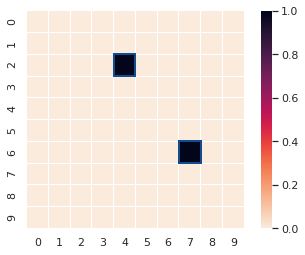

In [8]:
n_actions_per_dim = 10
ax = sns.heatmap(np.array([reward_fn(i, noise_std=0.0) for i in range(n_actions_per_dim ** 2)]).reshape(
    n_actions_per_dim, n_actions_per_dim), square=True, cmap=sns.cm.rocket_r, linewidths=.1)
rect = patches.Rectangle((7,6),1,1,linewidth=2,edgecolor='#0E4D92',facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((4,2),1,1,linewidth=2,edgecolor='#0E4D92',facecolor='none')
ax.add_patch(rect)
plt.show()

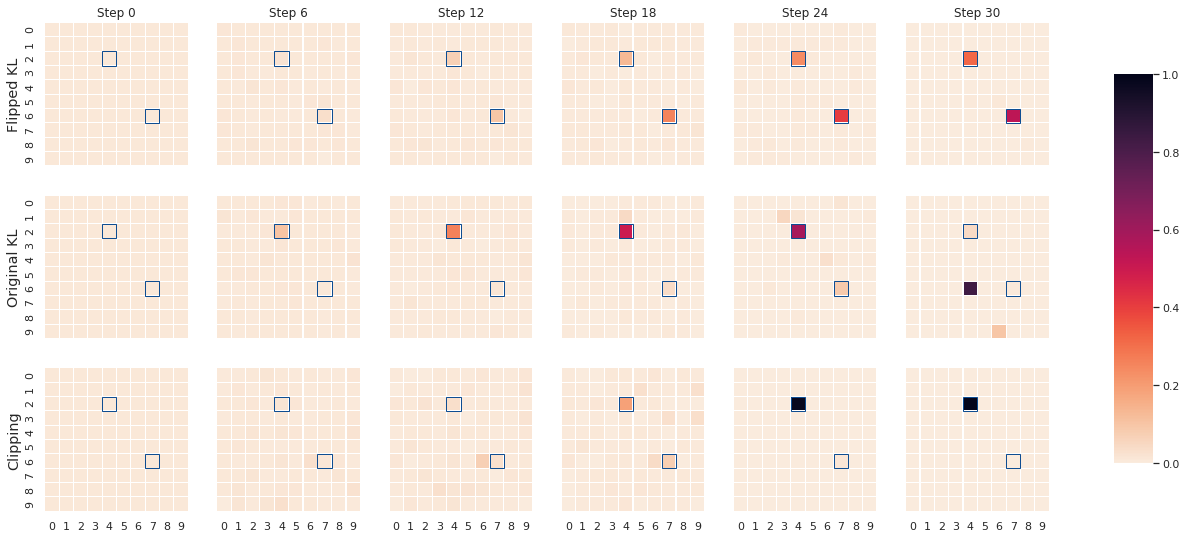

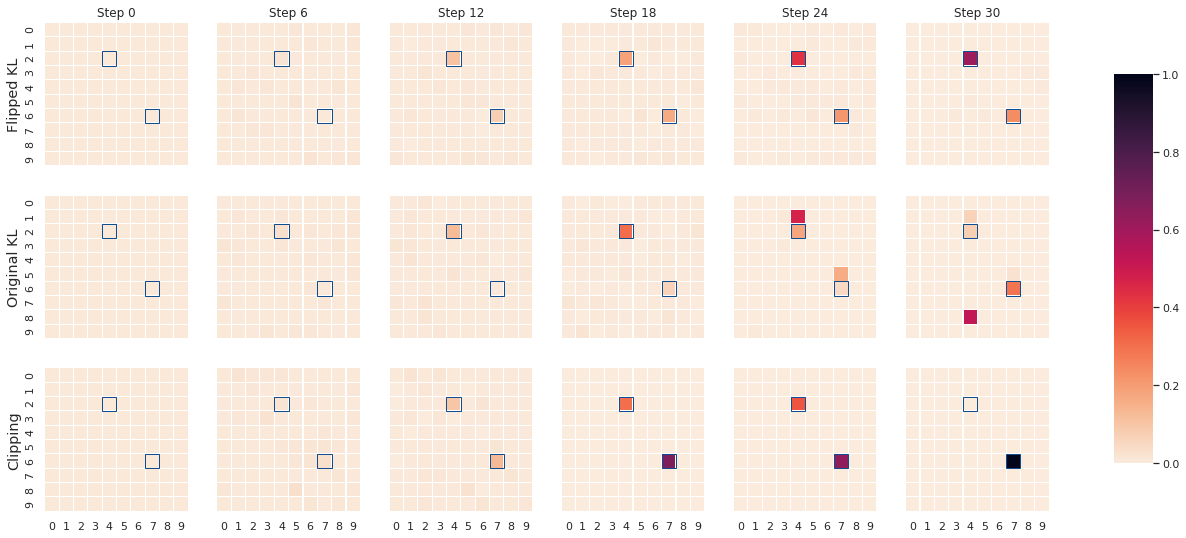

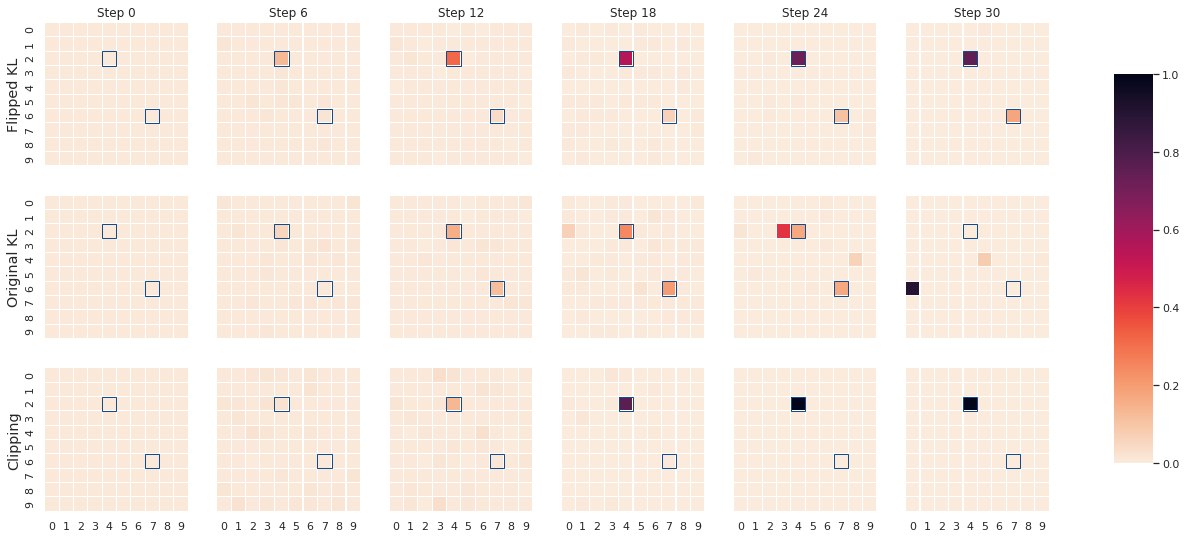

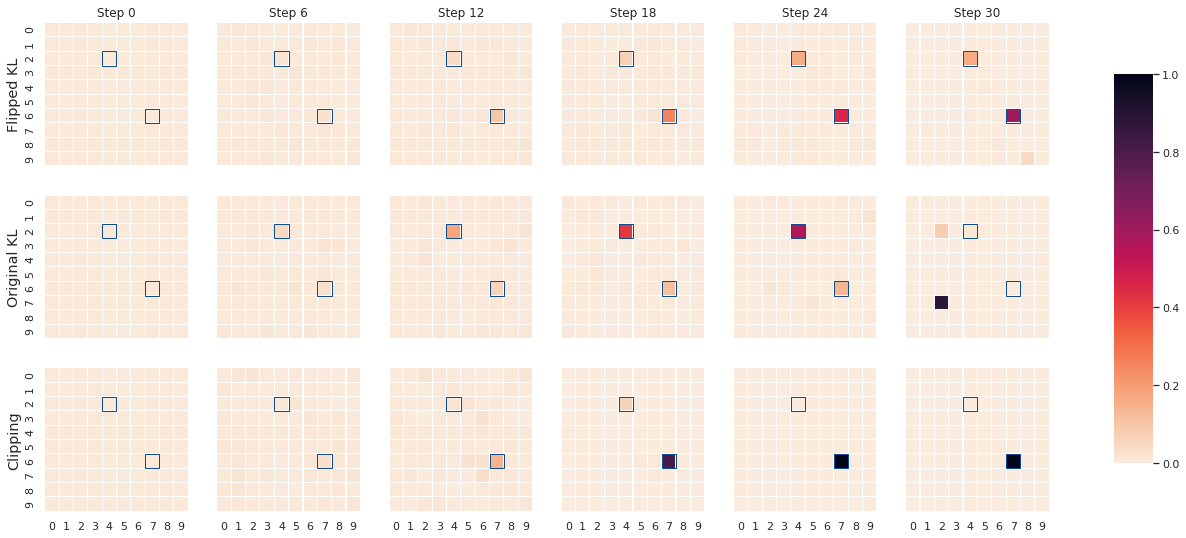

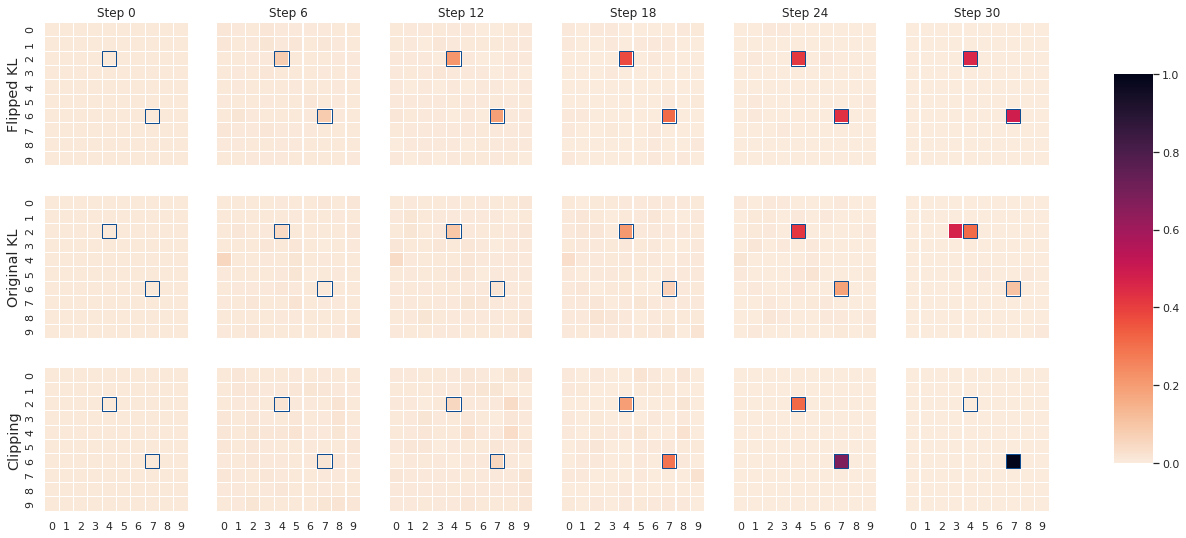

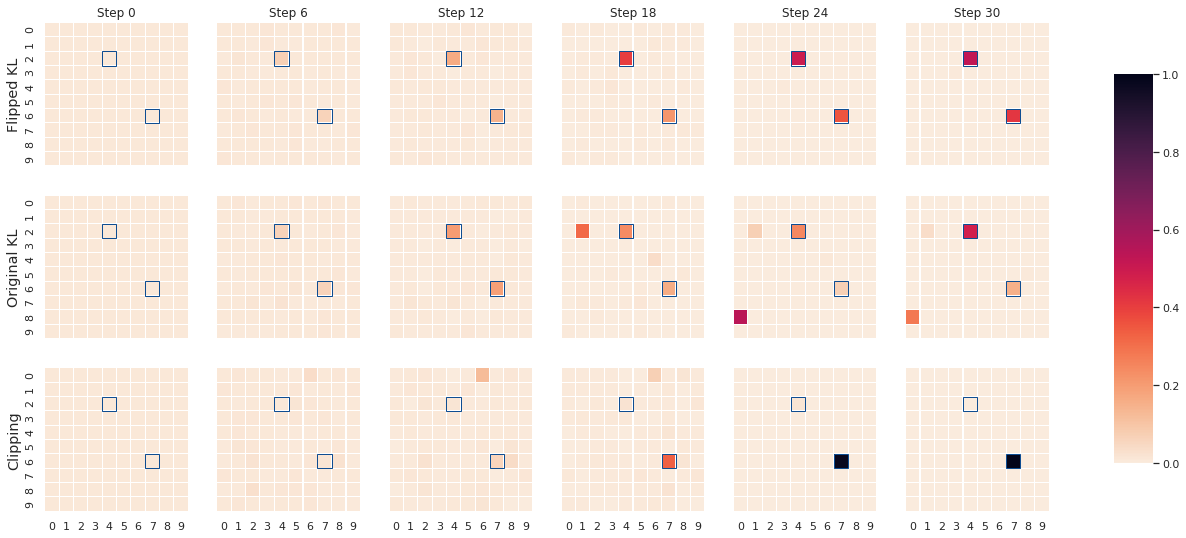

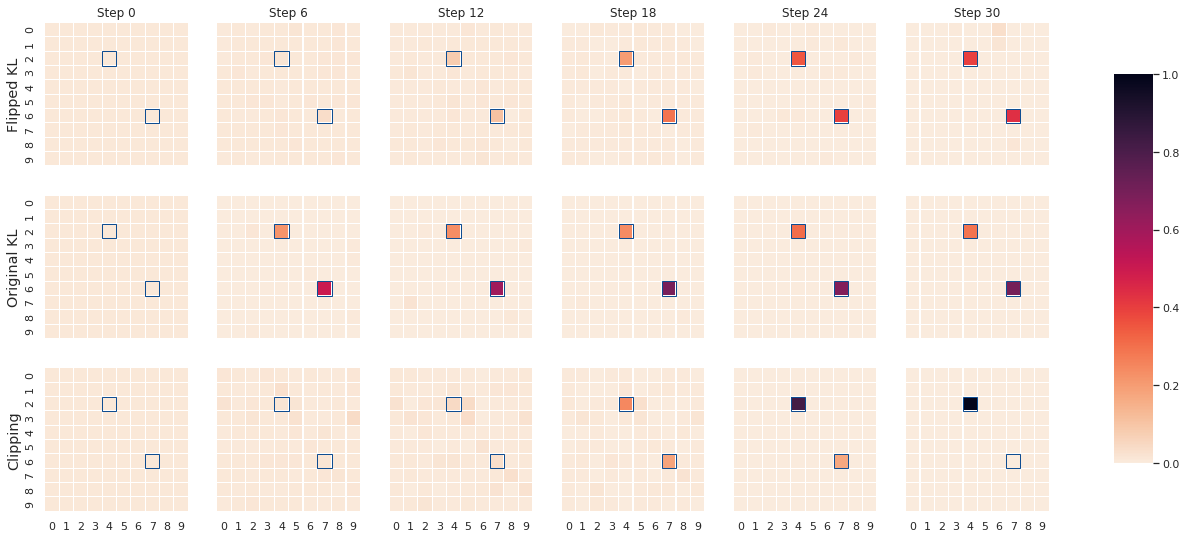

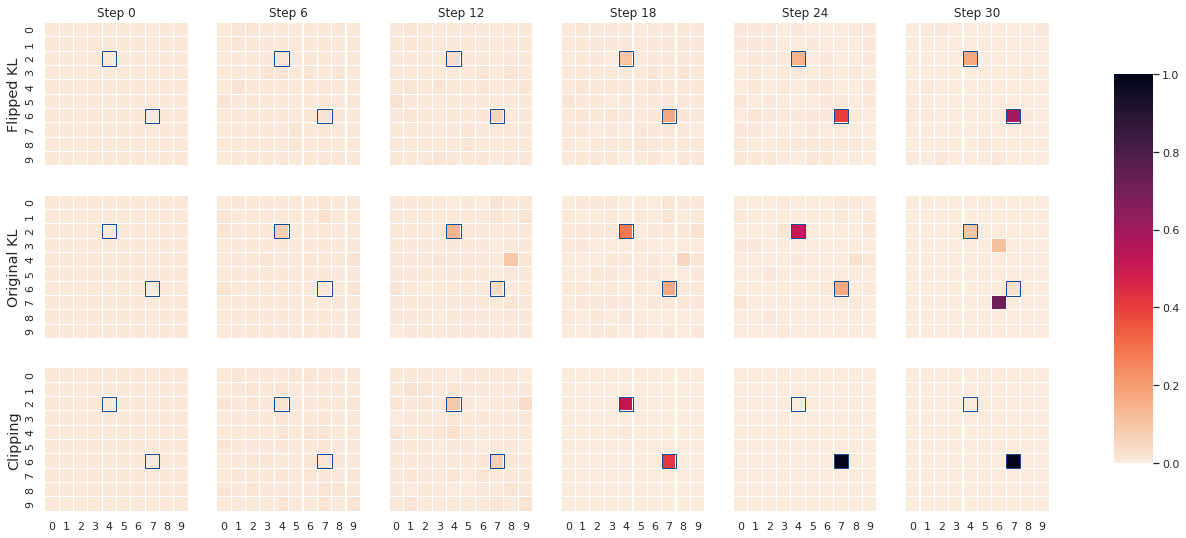

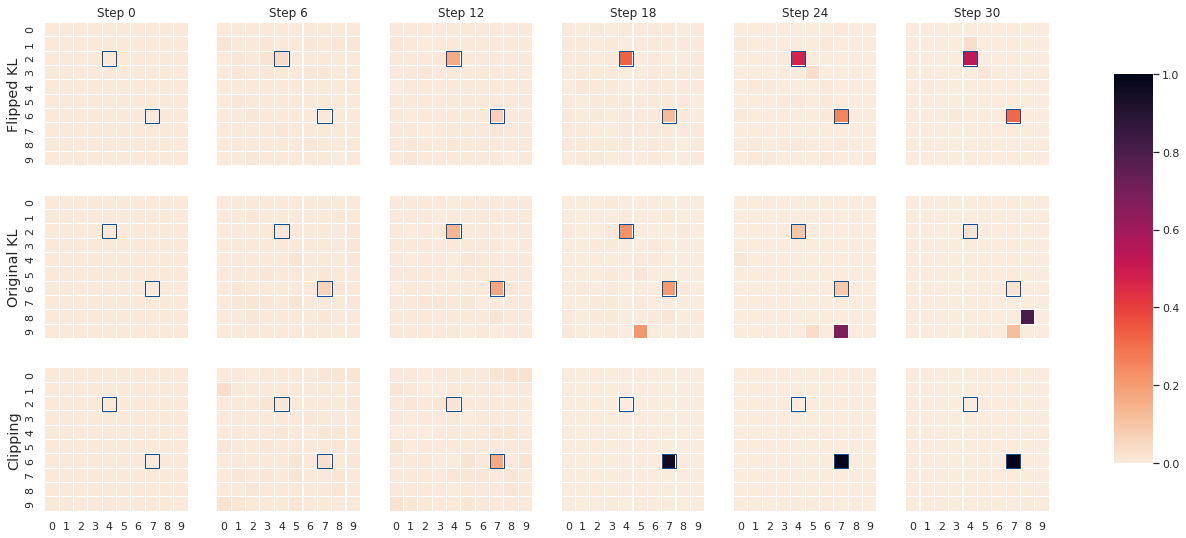

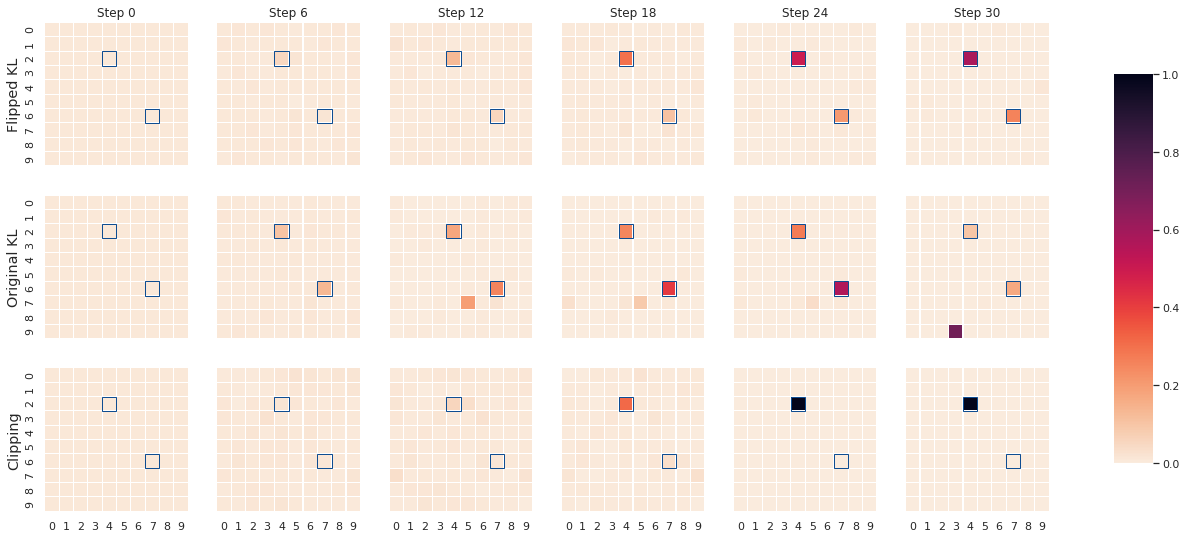

In [9]:
noise_std = 0.3
noisy_reward_fn = functools.partial(reward_fn, noise_std=noise_std)
n_steps = 30
plot_freq = 6
n_actions_per_dim = 10
n_trials = 10

method_names = ['Flipped KL', 'Original KL', 'Clipping']
params_list = [flipped_kl_params, original_kl_params, clip_params]

n_cols = int(np.ceil(n_steps / plot_freq)) + 1

np.random.seed(0)

for _ in range(n_trials):
    fig, axes = plt.subplots(3, n_cols, figsize=(3*n_cols, 9), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.95, .2, .03, .6])

    kl_new_to_old = [[], [], []]
    kl_old_to_new = [[], [], []]
    for i, params in enumerate(params_list):
        policy = Discrete2DPolicy(n_actions_per_dim=n_actions_per_dim, init_probs=None)
        for j in range(n_steps):
            if j % plot_freq == 0:
                policy.plot(ax=axes[i][int(j/plot_freq)])
            _, kl_new_to_old_this_step, kl_old_to_new_this_step = ppo_step(
                policy, params, noisy_reward_fn, normalize_adv=False)
            kl_new_to_old[i].append(kl_new_to_old_this_step)
            kl_old_to_new[i].append(kl_old_to_new_this_step)
        # Share one colorbar for all subfigures.
        policy.plot(ax=axes[i][-1], colorbar_ax=cbar_ax if i == 0 else None)

    for i, name in enumerate(method_names):
        axes[i][0].set_ylabel(name, size='large')
    for j in range(0, n_steps+1, plot_freq):
        axes[0][int(j/plot_freq)].set_title('Step %d' % j)
    for row in axes:
        for ax in row:
            rect = patches.Rectangle((4,2),1,1,linewidth=1,edgecolor='#0E4D92',facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((7,6),1,1,linewidth=1,edgecolor='#0E4D92',facecolor='none')
            ax.add_patch(rect)
    plt.show()

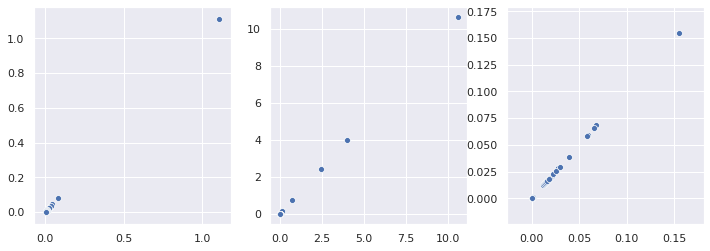

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, name in enumerate(method_names):
    sns.scatterplot(x=kl_new_to_old[i], y=kl_new_to_old[i], ax=axes[i])
plt.show()